In [1]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from __future__ import print_function
from PIL import Image
import numpy as np

from keras import backend as K
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras import metrics

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

from vgg16_avgPooling import VGG16_AVG
import matplotlib.pyplot as plt
from matplotlib import animation,rc
from IPython.display import HTML
import time

Using TensorFlow backend.


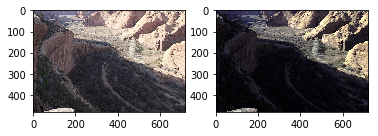

In [2]:
path = 'data/'
imageContent = Image.open(path + 'original.jpg')
width,height = imageContent.size
imageStyle = Image.open(path + 'enhanced.jpg')
imageStyle = imageStyle.resize((width,height), resample=0)
figure,axis = plt.subplots(1,2)
axis[0].imshow(imageContent)
axis[1].imshow(imageStyle)

In [3]:
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preprocess_vgg = lambda x: (x - vgg_mean)[:, :, :, ::-1]
reverse_vgg = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + vgg_mean, 0, 255)

In [4]:
content_array = np.expand_dims(np.array(imageContent), 0)
content_array = preprocess_vgg(content_array)

style_array = np.expand_dims(np.array(imageStyle), 0)
style_array = preprocess_vgg(style_array)

inShape = content_array.shape

In [5]:
model = VGG16_AVG(weights='imagenet',include_top=False, input_shape=inShape[1:])
outputs = {l.name: l.output for l in model.layers}
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 480, 720, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 480, 720, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 480, 720, 64)      36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, 240, 360, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 240, 360, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 240, 360, 128)     147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, 120, 180, 128)     0         
__________

In [6]:
content_selectedLayer = model.get_layer('block3_conv1').output
content_model = Model(model.input, content_selectedLayer)

style_selectedLayers = [outputs['block{}_conv2'.format(o)] for o in range(1,6)]
style_model = Model(model.input, style_selectedLayers)
style_weights = [0.1,0.2,0.2,0.25,0.25]

#Forward pass through the CNN to get activation of last conv layer
content_target = K.variable(content_model.predict(content_array))
style_target = [K.variable(i) for i in style_model.predict(style_array)]

In [7]:
#Create evaluator class so we can use sklearn
class Evaluator(object):
    def __init__(self, fn, inShape):
        self.fn, self.inShape = fn, inShape
        
    def loss(self, x):
        loss_, self.gradient_values = self.fn([x.reshape(self.inShape)])
        return loss_.astype(np.float64)

    def grads(self, x):
        return self.gradient_values.flatten().astype(np.float64)
    
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

def content_loss(content_selectedLayer, content_target):
    return K.mean(metrics.mse(content_selectedLayer, content_target))

def style_loss(style_selectedLayers, style_target):
    return K.mean(metrics.mse(gram_matrix(style_selectedLayers),\
                              gram_matrix(style_target)))

In [8]:
content_loss = content_loss(content_selectedLayer, content_target)
style_loss = sum(style_loss(l1[0], l2[0])*w
           for l1,l2,w in zip(style_selectedLayers, style_target, style_weights))

In [9]:
content_loss_weight = 0.15
style_loss_weight = 0.65
total_loss = (content_loss_weight*content_loss) + \
            (style_loss_weight*style_loss)
gradients = K.gradients(total_loss, model.input)
fn = K.function([model.input], [total_loss] + gradients)
evaluator = Evaluator(fn, inShape)

In [10]:
def generate_image(evaluator, epoch, generated):
    start_time = time.time()
    for i in range(epoch):
        generated, min_val, info = fmin_l_bfgs_b(evaluator.loss,\
                generated.flatten(),fprime=evaluator.grads, maxfun=20)
        generated = np.clip(generated, -127,127)
        print('Epoch #%d Loss: %f' % (i+1,min_val))
        im = reverse_vgg(generated.copy(), inShape)[0]
        imsave(path + 'generated_image_' + str(i) + '.jpg', im)
    end_time = time.time()
    print("Time needed: %d seconds" % (end_time - start_time))
    return generated

([], <a list of 0 Text yticklabel objects>)

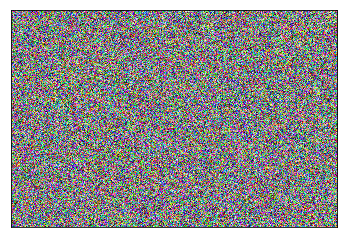

In [11]:
imageGenerated = np.random.random(inShape)
plt.imshow(imageGenerated[0])
plt.xticks([])
plt.yticks([])

In [12]:
epochs=13
imageGenerated = generate_image(evaluator, epochs, imageGenerated)

Epoch #1 Loss: 10501.986328
Epoch #2 Loss: 3263.949951
Epoch #3 Loss: 1630.470581
Epoch #4 Loss: 1296.392212
Epoch #5 Loss: 1150.873779
Epoch #6 Loss: 1061.835449
Epoch #7 Loss: 999.739136
Epoch #8 Loss: 956.262512
Epoch #9 Loss: 924.243530
Epoch #10 Loss: 899.032898
Epoch #11 Loss: 880.023132
Epoch #12 Loss: 865.148682
Epoch #13 Loss: 853.151855
Time needed: 53 seconds


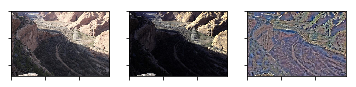

In [13]:
figure,axis = plt.subplots(1,3)
axis[0].imshow(imageContent)
axis[1].imshow(imageStyle)

axis[0].set_yticklabels([])
axis[0].set_xticklabels([])
axis[1].set_yticklabels([])
axis[1].set_xticklabels([])

def animate(i):
    axis[2].set_yticklabels([])
    axis[2].set_xticklabels([])
    axis[2].imshow(Image.open(path + 'generated_image_' + str(i) + '.jpg'))

anim = animation.FuncAnimation(figure, animate, frames=13, interval=500)
HTML(anim.to_html5_video())